In [2]:
import sys, os
import numpy as np
import scipy
import matplotlib.pyplot as plt
import glob
from mpl_toolkits.basemap import Basemap
from descartes import PolygonPatch
from shapely.geometry import Polygon
from matplotlib.patches import Ellipse

from netCDF4 import Dataset as NCDataset
from obspy.core import Stream, UTCDateTime

sys.path.append('/g/data/ha3/rakib/seismic/pst/passive-seismic')
from xcorqc.correlator import Dataset

import matplotlib.dates as mdates
import datetime

%matplotlib inline


CORR_PATH = '/g/data/ha3/rakib/xcorTest/7G/'

/apps/matplotlib/1.5.1-py2.7/lib/python2.7/site-packages/matplotlib-1.5.1-py2.7-linux-x86_64.egg/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
ds = Dataset('/g/data/ha3/Passive/_ANU/7G(2013-2015)/ASDF/7G(2013-2015).h5')
#ds = Dataset('/g/data/ha3/Passive/_ANU/7X(2009-2011)/ASDF/7X(2009-2011).h5')
corrFiles = glob.glob(CORR_PATH + '/*.nc')

centre: 143.330734, -29.030768


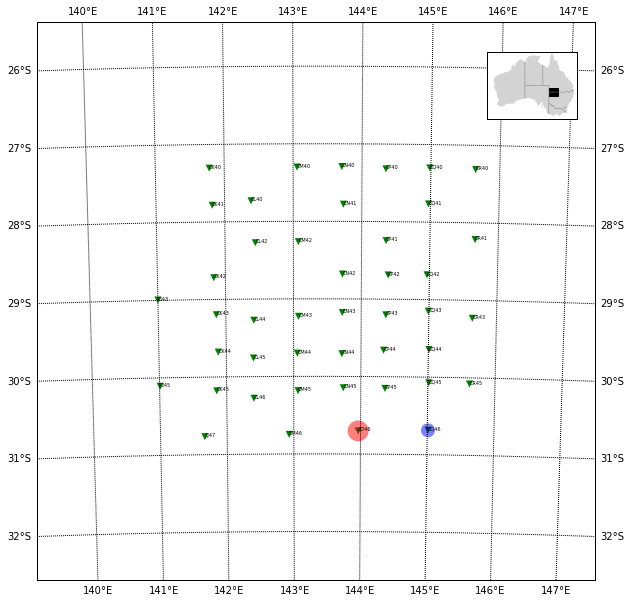

In [12]:
def drawBBox( minLon, minLat, maxLon, maxLat, bm, **kwargs):
    bblons = np.array([minLon, maxLon, maxLon, minLon, minLon])
    bblats = np.array([minLat, minLat, maxLat, maxLat, minLat])
    
    x, y = bm( bblons, bblats )
    xy = zip(x,y)
    poly = Polygon(xy)
    bm.ax.add_patch(PolygonPatch(poly, **kwargs))
#end func

fig = plt.figure(figsize=(10,10))

minLon = 1e32
maxLon = -1e32
minLat = 1e32
maxLat = -1e32
for s in ds.stations:
    lon,lat = ds.stations_metadata[s].coordinates['longitude'], \
              ds.stations_metadata[s].coordinates['latitude']
    
    if(minLon > lon): minLon = lon
    if(maxLon < lon): maxLon = lon
    if(minLat > lat): minLat = lat
    if(maxLat < lat): maxLat = lat        
# end for

m = Basemap(width=800000,height=800000,projection='lcc',
            resolution='l',lat_1=minLat,lat_2=maxLat,
            lat_0=(minLat+maxLat)/2., lon_0=(minLon + maxLon)/2.)
# draw coastlines.
m.drawcoastlines()

#draw grid
parallels = np.linspace(np.floor(minLat)-5, np.ceil(maxLat)+5, \
                        int((np.ceil(maxLat)+5) - (np.floor(minLat)-5))+1)
m.drawparallels(parallels,labels=[True,True,False,False])
meridians = np.linspace(np.floor(minLon)-5, np.ceil(maxLon)+5, \
                        int((np.ceil(maxLon)+5) - (np.floor(minLon)-5))+1)
m.drawmeridians(meridians,labels=[False,False,True,True])

# plot stations
for s in ds.stations:
    lon,lat = ds.stations_metadata[s].coordinates['longitude'], \
              ds.stations_metadata[s].coordinates['latitude']

    px,py = m(lon, lat)
    pxl,pyl = m(lon, lat-0.1)
    m.scatter(px, py, 50, marker='v', c='g', edgecolor='none')    
    plt.annotate(s, xy=(px, py), fontsize=5)
# end for

for fn in corrFiles:
    pair = os.path.basename(fn)
    station = pair.split('.')[0]
    if(station != 'CO46'): continue
    
    nbrs = []
    for nfn in corrFiles:
        npair = os.path.basename(nfn)
        nstation = npair.split('.')[0]
        
        if(nstation in station): nbrs.append(npair.split('.')[1])
    # end for
    
    lon,lat = ds.stations_metadata[station].coordinates['longitude'], \
              ds.stations_metadata[station].coordinates['latitude']    
    e = Ellipse(m(lon, lat), 3e4, 3e4, color='red', ec='none', alpha=0.5)
    fig.axes[0].add_artist(e)
    
    for nbr in nbrs:
        if(nbr != 'CQ46'): continue
        lon,lat = ds.stations_metadata[nbr].coordinates['longitude'], \
                  ds.stations_metadata[nbr].coordinates['latitude']    
        e = Ellipse(m(lon, lat), 2e4, 2e4, color='blue', ec='none', alpha=0.5)
        fig.axes[0].add_artist(e)
    # end for
    
    break
# end for


insetAx = fig.add_axes([0.75,0.75,0.125,0.125])
mInset = Basemap(resolution='c', # c, l, i, h, f or None
            ax=insetAx,
            projection='merc',
            lat_0=-20, lon_0=132,
            llcrnrlon=110, llcrnrlat=-40, urcrnrlon=155, urcrnrlat=-10)
#mInset.drawcoastlines()
mInset.fillcontinents(color='lightgray')
mInset.drawstates(color="grey")

drawBBox(minLon, minLat, maxLon, maxLat, mInset, fill='True', facecolor='k')

print 'centre: %lf, %lf'%(np.mean([minLon, maxLon]), np.mean([minLat, maxLat]))

plt.legend()
plt.savefig('./stations.pdf')


['CM45', 'CQ46', 'CM46', 'CN45', 'CP45']
/g/data/ha3/rakib/xcorTest/7G/test/CO46.QLP.good.nc
(339, 24001)
(339, 359999)
0.0 1.0


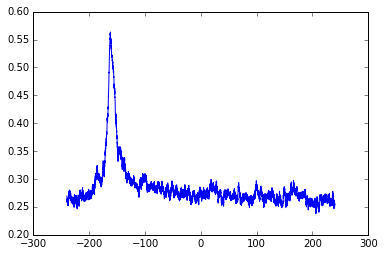

In [15]:

fig = plt.figure(figsize=(10,10))

for fn in corrFiles:
    pair = os.path.basename(fn)
    station = pair.split('.')[0]
    
    station = 'CO46'
    
    nbrs = []
    for nfn in corrFiles:
        npair = os.path.basename(nfn)
        nstation = npair.split('.')[0]
        
        if(nstation in station): nbrs.append(npair.split('.')[1])
    # end for
    
    print nbrs
    
    #fn = CORR_PATH+'/%s.%s.nc'%(station, nbrs[1])
    fn = '/g/data/ha3/rakib/xcorTest/7G/test/CO46.QLP.good.nc'
    print fn 
    d = NCDataset(fn, 'r')
    
    sTimes = d.variables['IntervalStartTimes'][:]
    lag = d.variables['lag'][:]
    xcorr = d.variables['xcorr'][:, :]
    
    #xcorr = np.ma.masked_array(xcorr, mask=xcorr==0)
    
    dlag = 12000
    gx, gy = np.meshgrid(lag[lag.shape[0]/2-dlag:lag.shape[0]/2+dlag+1], sTimes)
    
    print gx.shape
    print xcorr.shape
    
    print np.min(xcorr[:, lag.shape[0]/2-dlag:lag.shape[0]/2+dlag+1]), \
            np.max(xcorr[:, lag.shape[0]/2-dlag:lag.shape[0]/2+dlag+1])
    
    labels=[]
    for st in sTimes: labels.append(UTCDateTime(st).strftime("%y-%m-%d"))
    
    plt.pcolormesh(gx, gy, xcorr[:, lag.shape[0]/2-dlag:lag.shape[0]/2+dlag+1], 
                   cmap='Spectral_r', vmin=0, vmax=1)
    plt.yticks(sTimes[::7], labels[::7])
    
    t = np.array(sTimes)
    g = np.gradient(t)
    indices = np.argwhere(g > (np.mean(g) + 2*np.std(g)))
    
    for i,idx in enumerate(indices[::2]):
        bx = np.array([np.min(gx), np.max(gx), np.max(gx), np.min(gx), np.min(gx)])
        by = np.array([sTimes[idx], sTimes[idx], sTimes[indices[i+1]], sTimes[indices[i+1]], sTimes[idx]])
    
        xy = zip(bx,by)
        poly = Polygon(xy)
        fig.axes[0].add_patch(PolygonPatch(poly, facecolor='white', ec='red'))
    # end for
    
    plt.colorbar()
    #fig.axes[0].get_xaxis().set_visible(False)
    #fig.axes[0].get_yaxis().set_visible(False)    
    #for spine in plt.gca().spines.values(): spine.set_visible(False)    
    plt.savefig('./a.png', dpi=300)
    
    plt.close()
    plt.plot(gx[0, :], np.mean(xcorr[:, lag.shape[0]/2-dlag:lag.shape[0]/2+dlag+1], axis=0))
    plt.savefig('./c.png')
    d.close()    
    break
# end for


[[1421193600]
 [1423872000]]
[[235]]


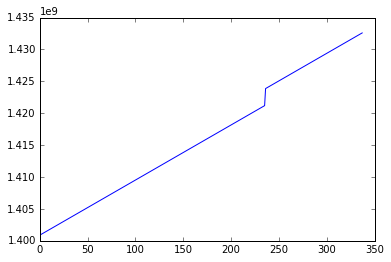

In [21]:
ax = plt.subplot()

t = np.array(sTimes)
#t[50:] = t[50:]+1e6

g = np.gradient(t)
ax.plot(t)
#ax.plot(scipy.signal.detrend(t))
#ax.plot(g)

indices = np.argwhere(g > (np.mean(g) + 2*np.std(g)))

print t[indices]

print indices[::2]

#ax.plot(np.gradient(sTimes))

/g/data/ha3/rakib/xcorTest/7G//CO46.CQ46.nc
5.7307925e-06 1.0
(452, 1201)
(452, 1201)


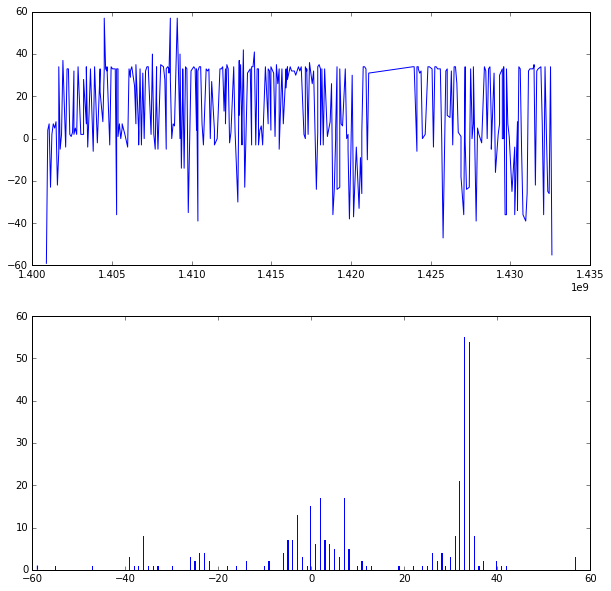

In [12]:
fig, (ax1, ax2) = plt.subplots(2,1)

fig.set_size_inches(10, 10)
for fn in corrFiles:
    pair = os.path.basename(fn)
    station = pair.split('.')[0]
    
    station = 'CO46'

    nbrs = []
    for nfn in corrFiles:
        npair = os.path.basename(nfn)
        nstation = npair.split('.')[0]
        
        if(nstation in station): nbrs.append(npair.split('.')[1])
    # end for
    
    fn = CORR_PATH+'/%s.%s.nc'%(station, nbrs[1])
    print fn 
    d = NCDataset(fn, 'r')
    
    sTimes = d.variables['IntervalStartTimes'][:]
    lag = d.variables['lag'][:]
    xcorr = d.variables['xcorr'][:, :]
    
    xcorr = np.ma.masked_array(xcorr, mask=xcorr==0)
        
    xcorr = xcorr[:, lag.shape[0]/2-600:lag.shape[0]/2+601]
    lag = lag[lag.shape[0]/2-600:lag.shape[0]/2+601]

    print np.min(xcorr), np.max(xcorr)
    
    maxCorrLags = np.zeros_like(sTimes)
    for i in range(len(sTimes)):
        if(np.ma.is_masked(xcorr[i, :])):
            maxCorrLags[i] = -999
        else:
            maxCorrLags[i] = lag[np.argmax(xcorr[i, :])]
    # end for
    
    ax1.plot(sTimes[maxCorrLags!=-999], maxCorrLags[maxCorrLags!=-999])
    
    ax1.set_ylim(-60, 60)
    
    ax2.hist(maxCorrLags[maxCorrLags!=-999], bins=len(sTimes), edgecolor='none')
    
    print gx.shape
    print xcorr.shape
    
    plt.savefig('./b.png', dpi=300)
    d.close()    
    break
# end for